# Day 1&2: Feed forward Neural Network

## Learning goals

### Google Colab
*   Connecting to your Google Drive
*   Setting up a GPU Runtime with TF2.0

### Setting up a model
*   Get familiar with the TF Keras API
*   Create a simple feed forward NN with the sequencial API for classification and regression
  * Define a loss function
  * Define layers with different activation functions
  * Use dropout layers
*   Define metrics
*   Optional: Use the functional API

### Model improvements
*   Handle imbalanced classes
*   Define a callback for early stopping

### Visualize and interpret results
*   Visualize and interpret the training history
*   Visualize and evaluate output metrics

### Optimize the performance
  * Try different learning rates
  * Try different activation functions
  * Try more complex NN structures
  * Try different types of regularization

### Bonus
  * Provoke overfitting and underfitting
  * Use Tensorboard for monitoring training and performance
  * Optimize hyperparameters and analyze the results with Tensorboard

## Feed Forward NN for Structured Data

### Sources:
Inspired by https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

### Description:
You are provided with a data set of almost 100,000 job ads from a job platform. In order to make their services more attractive they want to introduce a new feature which predicts the expected number of views for a new job ad based on the job title and a few other features. This will help their customers to create job titels that attract more views.

Some of our students have already vectorized the job titles. (Word embeddings generated by Google's BERT NLP model have been created and provided. Next week you will learn how to do this yourself!) In addition, you have some metadata and some general features of the job titles (e.g. all letters capitalized, ...).

Since there are several hundreds of features, using a neural network seems to be the most promising approach.


## Exercise 1: Classification

Because you know that it might be quite challenging to predict the exact number of ad views, besides predicting the exact view count we also want to try to convert it into a classification problem by binning the number of views.

The code for splitting the views in bins as well as the code for preprocessing the numerical and categorical features is provided.

### Your tasks:
Treat the problem as a classification task, by binning the target values. The ranges of the bins are provided in the configuration file.  

  a) Understand the basic structure of the dataset and the preprocessing steps.

  b) Have a look at the tutorial on imbalanced data on tensorflow.org: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data 

  c) Build a model with the sequential TF Keras API. Start with the provided function for creating a simple neural network. This can be modified later.

  d) Add different metrics that seem to be meaningful for this problem. Since TF does only provide the basic metrics by default, a function for calculating the macro averaged F1 score is provided. Have a look at this funciton!

https://www.datascienceblog.net/post/machine-learning/performance-measures-multi-class-problems/

  e) Test the difference between `categorical_crossentropy` and `sparse_categorical_crossentropy`.

  f) Add class weights for improving the performance of small classes. Visualize the effect in a confusion matrix.

  g) Add early stopping based on the F1 score of a validation data set. (Use a train-test split for creating a validation data set)

  h) Try to improve the performance of the model by modifying the structure of the NN (more layers, different number of neurons, ...) or using different learning rates. Try different regularization methods, e. g. l1 or l2 regularization, and [dropout](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf) to reduce overfitting.



### Questions:
  * What is the difference between macro and micro averaged scores? Why could micro averaged scores be missleading for a imbalanced data set?
  * How does early stopping work? What are the advantages of using it?


# Code


## Imports

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
# Imports
import tensorflow as tf
from tensorflow import keras
# import tensorflow_addons as tfa

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

import tempfile
import os
import yaml
import sys

In [0]:
mpl.rcParams['figure.figsize'] = (12, 10)


## Load data and functions
Connect to Google Drive. Code snippets for this and other frequently required operations can be found in the `Code snippets` tab of Google Colab.

You have to authorizate Google Colab to access your Google Drive.

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Set working directory
You need to change this to the directory where you have saved this project.

In [0]:
project_dir = "/gdrive/My Drive/Propulsion Academy/03_Bootcamps/Data Science/Teaching Material/NN & CNN/dev/week-7-exercises/Day1+2_feed_forward_NN"
%cd {project_dir}

/gdrive/My Drive/Propulsion Academy/03_Bootcamps/Data Science/Teaching Material/NN & CNN/dev/week-7-exercises/Day1+2_feed_forward_NN


### Import custom functions
We import some additional functions that are provided in the `functions` directory. Use the same kind of structure to import your own functions.

In order to be able to load `.py` files from the functions folder we first have to add its location to the `sys.path` variable. 

To be sure that the correct function is loaded we insert its location at the very begining of `sys.path`. https://stackoverflow.com/questions/31291608/effect-of-using-sys-path-insert0-path-and-sys-pathappend-when-loading-modul

In [0]:
# Add the corresponding Google Drive folder to sys.path
sys.path.insert(0, os.path.join(project_dir, 'functions'))

# import functions
import tf_metrics
import evaluate_results
import data_loader
import nn_models

### Load configuration file
All required paths for loading the data and additional parameters on how to pre-process it are saved in a configuration file. We use a YAML file.
YAML as a human friendly data serialization standard. You can see it as a more beautiful version of JSON.

It is compatible with all relevant programming languages.

Have a look at the file which is in the `configuration` directory. Add your own parameters which are required for this project.

In [0]:
config_file_path = "./configuration/config_file.yml"
config = yaml.safe_load(open(config_file_path))
print(yaml.dump(config, indent=2))

features:
  categorical: [month, package_id, industry_name, city]
  numerical: [contract_pct_from, contract_pct_to, title_num_words]
  passthrough: [title_aggressive, title_female, title_percent, title_location, title_diploma,
    title_chief, title_prob_en, title_prob_de, title_prob_fr]
paths: {features_test: ./data/jobs_features_test.csv, features_train: ./data/jobs_features_train.csv,
  target_train: ./data/jobs_10dviews_train.csv}
target:
  bins: [0, 10000, 20000, 50000, 100000, 200000, .inf]



### Load the data set from Google Drive

In [0]:
# load training data
X_train_, y_train_, X_test = data_loader.load_data(project_dir, config)

### Inspect the loaded dataset

In [0]:
print("Shape of data is ", X_train_.shape)
X_train_.describe()

Shape of data is  (81388, 785)


,contract_pct_from,contract_pct_to,title_num_words,title_aggressive,title_female,title_percent,title_location,title_diploma,title_chief,title_prob_en,title_prob_de,title_prob_fr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
count,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,...,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000
mean,90.633275,96.474714,4.665258,0.039121,0.521404,0.382046,0.011709,0.040116,0.002064,0.189532,0.680005,0.024746,-0.262695,-0.081360,0.059723,-0.276611,0.351807,0.007587,0.328369,0.139038,-0.160400,-0.341064,-0.050812,-0.291748,0.278809,0.316406,-0.272705,0.344238,-0.072571,-0.161621,-0.092773,0.053772,-0.331787,0.005379,-0.080933,0.365234,0.340576,-0.063049,0.050629,-0.072266,...,-0.003885,-0.293945,0.072388,0.055054,-0.033813,0.152222,-0.246582,0.166382,-0.006775,0.214233,-0.220825,0.422363,-0.042908,0.309570,-0.350098,0.110107,-0.193115,0.065125,-0.257812,-0.136719,0.024734,-0.131714,0.343506,-0.175781,-0.022964,-0.224365,-0.162109,-0.201538,-0.316895,-0.232178,0.430176,-0.403320,0.229614,-0.223511,-0.050659,-0.060547,-0.195557,-0.345459,-0.012093,-0.167358
std,18.179258,12.141145,2.481178,0.193885,0.499545,0.485891,0.107575,0.196234,0.045387,0.370144,0.441872,0.146484,0.293457,0.249023,0.261230,0.258057,0.263672,0.221069,0.359131,0.246094,0.262207,0.220581,0.196045,0.310059,0.218628,0.212036,0.257812,0.329590,0.203003,0.298584,0.281982,0.222168,0.245239,0.238281,0.243652,0.263184,0.256592,0.232666,0.251709,0.306885,...,0.217529,0.258301,0.254150,0.301514,0.218994,0.317383,0.274902,0.208740,0.322266,0.289307,0.275879,0.326904,0.219360,0.261719,0.293213,0.237915,0.220459,0.266602,0.274658,0.255127,0.284912,0.271729,0.310059,0.375732,0.677734,0.252197,0.246704,0.236572,0.288818,0.258789,0.275635,0.318604,0.238892,0.209961,0.310547,0.261475,0.244263,0.215820,0.188843,0.265137
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.454102,-1.500977,-1.343750,-1.681641,-0.941895,-1.046875,-0.886230,-0.867188,-1.428711,-1.497070,-0.862793,-1.574219,-0.854004,-0.590820,-1.564453,-1.136719,-1.098633,-1.077148,-1.237305,-0.916016,-1.345703,-1.133789,-1.242188,-0.740723,-1.365234,-0.985352,-1.442383,-1.048828,...,-1.007812,-1.264648,-0.737793,-1.043945,-1.010742,-1.610352,-1.709961,-0.728027,-1.219727,-0.985840,-1.507812,-0.722168,-1.152344,-1.120117,-1.238281,-1.153320,-1.157227,-1.080078,-1.401367,-1.351562,-1.289062,-1.041016,-1.147461,-1.359375,-6.027344,-1.473633,-1.374023,-1.381836,-1.464844,-1.450195,-0.723633,-1.665039,-0.738281,-1.167969,-1.069336,-1.013672,-1.284180,-1.248047,-0.867188,-1.287109
25%,80.000000,100.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.466309,-0.240479,-0.105774,-0.439941,0.169678,-0.147461,0.065308,-0.018616,-0.330078,-0.481201,-0.180054,-0.520020,0.

,0
count,8.138800e+04
mean,6.470638e+04
std,6.636027e+04
min,0.000000e+00
25%,2.523000e+04
50%,4.655000e+04
75%,8.168000e+04
max,4.880180e+06


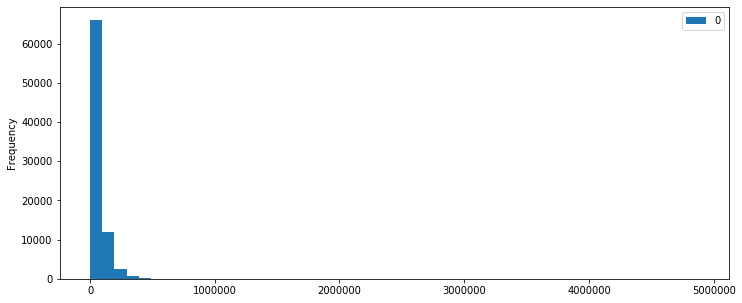

In [0]:
y_train_.plot.hist(bins=50, figsize=[12,5])
y_train_.describe()

## Preprocessing


### Create binned labels
You can use the `cut` function from `pandas`.



In [0]:
labels = np.arange(len(config['target']['bins'])-1)
y_train_cat_ = pd.cut(y_train_[0], bins=config['target']['bins'], labels=labels, include_lowest=True)
Y_train_cat_ = pd.get_dummies(y_train_cat_)

In [0]:
print('There are {} nans.'.format(y_train_cat_.isna().sum()))

There are 0 nans.


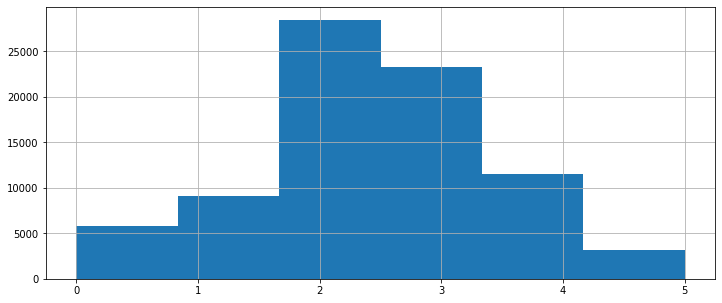

In [0]:
y_train_cat_.hist(bins=len(labels), figsize=[12, 5])

### Build a preprocessing pipeline

We use the column transformer from sklearn to apply different transformation on numerical and categorical features. Furthermore, some features don't have to be transformed and are just passed trough.

All required steps for creating a transformer are provided in the `data_loader` file. Have a look at it and follow the individual steps. I hope you remember from the machine learning module how it works. ;)

We manually add a list of strings of all the numbers from 0 to 767. These are the columns which contain a vectorised representation of the job titles. For now you don't need to understand their exact meaning and how they have been created. You are going to learn it next week. Just see them as a condensed numerical representation of the information contained in the job titles. Since these vectors are already normalised, we don't need to scale them.

In [0]:
data_transformer = data_loader.make_data_transformer(
    config['features']['numerical'],
    config['features']['categorical'],
    config['features']['passthrough'] + [str(number) for number in range(0,768)]
    )

### Train-test split

In [0]:
# split data into train and validation set
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_, 
    Y_train_cat_.to_numpy(), 
    test_size=0.2, 
    stratify=Y_train_cat_)

# apply preprocessing
X_train = data_transformer.fit_transform(X_train)
X_val = data_transformer.transform(X_val)
X_test = data_transformer.transform(X_test)

In [0]:
print('Training labels shape:', Y_train.shape)
print('Validation labels shape:', Y_val.shape)
print()
print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
# print('Test features shape:', X_test.shape)

Training labels shape: (65110, 6)
Validation labels shape: (16278, 6)

Training features shape: (65110, 829)
Validation features shape: (16278, 829)


## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer and an output softmax layer that returns the probability of belonging to a certain category.

### Define metrics

For our problem we would like to calculate a macro averaged F1 score. Since this is not available in the TensorFlow core library, we have to define our own function. 

Since this has to be defined via a computational graph on tensor objects, we have to use operators from the tensorflow library.

Since this is not trivial, you are provide with a ready made function which can be found in the file `functions/tf_metrics.py`.
Have a look at it and try to understand what it is doing.

You can define multiple metrics. So, let's use accuracy and our custum build macro averaged F1 score.

In [0]:
METRICS = ['accuracy', tf_metrics.tf_f1_score,]

## Build a simple model

Now create a simple model using a function which is provided in `functions/nn_models.py`. You can add there later your own more complex models.

Note: This model will not handle the class imbalance well. Also we don't have so far any kind of regularisation. Your task is to improve it later.

In [0]:
model = nn_models.make_default_model(X_train.shape[1], 
                                     Y_train.shape[1], 
                                     loss='categorical_crossentropy', 
                                     metrics=METRICS)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 100)               83000     
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 606       
Total params: 83,606
Trainable params: 83,606
Non-trainable params: 0
_________________________________________________________________


A more beautiful way to visualise the model is to use `keras.utils.plot_model`.

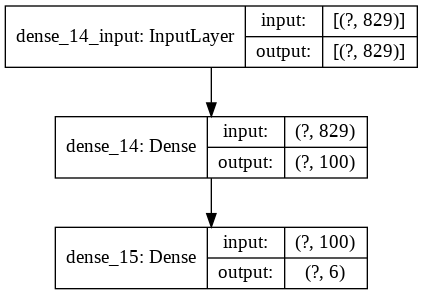

In [0]:
tempfile_path = os.path.join(tempfile.mkdtemp(),'my_first_model.png')
keras.utils.plot_model(model, tempfile_path, show_shapes=True)

Test run the model. Let's see whether our model can produce a prediction. If everyting is correct it will create an output array with 1 column for each target bin. (in our case it should be 6)

Since the model has been randomly initialized and hasn't been trained yet, the values of the output are meaningless. However, it shows whether we have set up the dimensions of the model correctly. 

In [0]:
model.predict(X_train[:5])

array([[0.14407259, 0.11432917, 0.14777046, 0.2642804 , 0.12356073,
        0.20598666],
       [0.19029826, 0.1774017 , 0.114463  , 0.19776964, 0.12793927,
        0.19212806],
       [0.08209834, 0.15417056, 0.11281771, 0.454197  , 0.06427409,
        0.13244236],
       [0.24052744, 0.17196089, 0.10659216, 0.17062685, 0.09033708,
        0.21995565],
       [0.10037071, 0.20705321, 0.11664247, 0.34388915, 0.0764456 ,
        0.15559883]], dtype=float32)

### Train the model
Let's train our model for a fix number of epochs. Let's start for example with 20 epochs.

If we provide a validation data set, tensorflow will calculate after each training epoch the metrics on our validation data.

In [0]:
EPOCHS = 20
BATCH_SIZE = 1024

model_simple = nn_models.make_default_model(X_train.shape[1], 
                                            Y_train.shape[1], 
                                            loss='categorical_crossentropy', 
                                            metrics=METRICS)

history_simple = model_simple.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, Y_val),
    verbose=1
    ) 

Train on 65110 samples, validate on 16278 samples
Epoch 1/20
65110/65110 [==============================] - 1s 15us/sample - loss: 1.4902 - accuracy: 0.3841 - tf_f1_score: 0.1680 - val_loss: 1.4148 - val_accuracy: 0.4107 - val_tf_f1_score: 0.1959
Epoch 2/20
65110/65110 [==============================] - 0s 7us/sample - loss: 1.3721 - accuracy: 0.4220 - tf_f1_score: 0.2368 - val_loss: 1.3535 - val_accuracy: 0.4278 - val_tf_f1_score: 0.2464
Epoch 3/20
65110/65110 [==============================] - 0s 7us/sample - loss: 1.3205 - accuracy: 0.4434 - tf_f1_score: 0.2979 - val_loss: 1.3205 - val_accuracy: 0.4364 - val_tf_f1_score: 0.2785
Epoch 4/20
65110/65110 [==============================] - 0s 7us/sample - loss: 1.2905 - accuracy: 0.4584 - tf_f1_score: 0.3392 - val_loss: 1.3044 - val_accuracy: 0.4485 - val_tf_f1_score: 0.3218
Epoch 5/20
65110/65110 [==============================] - 0s 7us/sample - loss: 1.2711 - accuracy: 0.4679 - tf_f1_score: 0.3574 - val_loss: 1.2886 - val_accuracy: 0.

Let's make a prediction and calculate the F1 score.

In [0]:
Y_pred = model_simple.predict(X_val)
tf_metrics.tf_f1_score(Y_val, Y_pred).numpy()

0.39581427

### Visualise the results
In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

You can use the functions from the provided in the `evaluate_results.py` file.


Note: That the validation curve somtimes performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

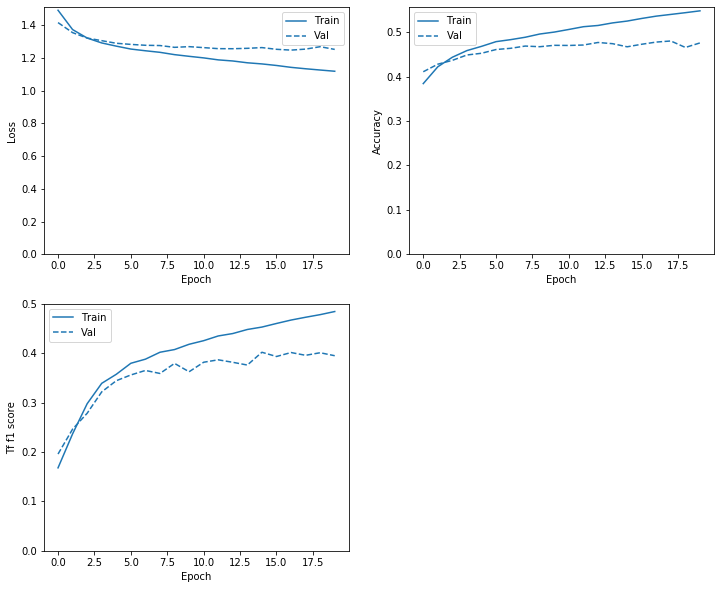

In [0]:
# Let's plot the training history
# Todo

loss :  1.2510786359997665
accuracy :  0.47561124
tf_f1_score :  0.39505047



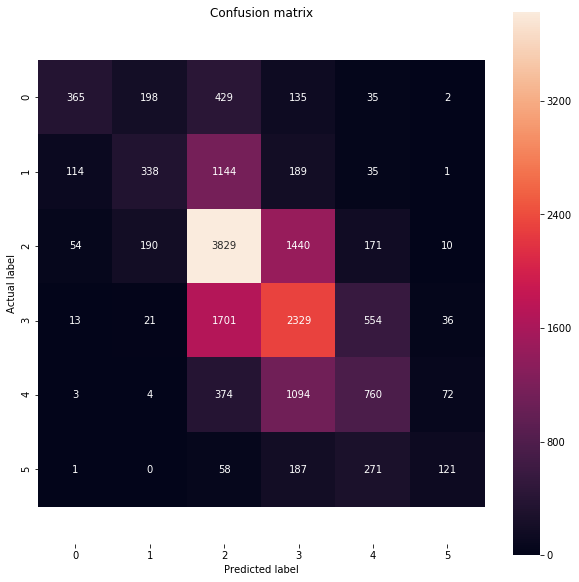

In [0]:
# And also a confusion matrix
# Todo

## Build a sparse version
Let's do the same with the sparse labels.

**Continue on your own!**